In [11]:
from torch.distributions import MultivariateNormal, StudentT
from numpy.random import standard_cauchy, standard_t
import torch
import numpy as np
import matplotlib.pyplot as plt

In [40]:
samples_1 = MultivariateNormal(
    loc=torch.Tensor([0, 0]), covariance_matrix=12.5*torch.eye(n=2)
).sample((10_000, )).numpy()
# samples_2 = standard_cauchy((20_000, )).reshape(-1, 2)
samples_2 = StudentT(df=3.0, loc=0.0, scale=2.0).sample((20_000,)).numpy().reshape(-1, 2)

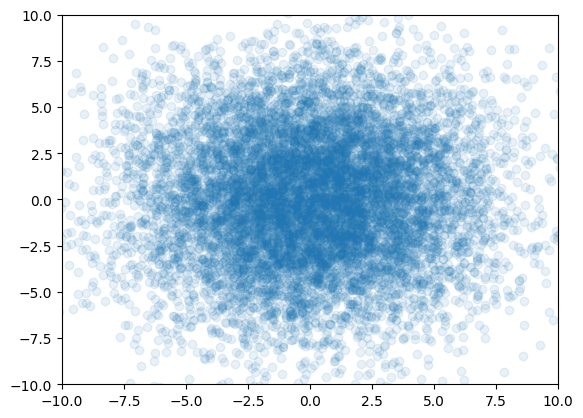

In [41]:
plt.scatter(samples_1[:, 0], samples_1[:, 1], alpha=0.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [ ]:
plt.scatter(samples_2[:, 0], samples_2[:, 1], alpha=0.1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

In [ ]:
from tqdm import tqdm
import dill
import click
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import torch
from torch.distributions import MultivariateNormal
from sbi.inference import FMPE, SNPE, NPSE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform
import sbibm
from lf2i.inference import LF2I
from lf2i.test_statistics.posterior import Posterior
from lf2i.test_statistics.waldo import Waldo
from lf2i.calibration.critical_values import train_qr_algorithm
from lf2i.utils.other_methods import hpd_region
from lf2i.plot.parameter_regions import plot_parameter_regions
from lf2i.plot.coverage_diagnostics import coverage_probability_plot
from lf2i.plot.power_diagnostics import set_size_plot
from tsi.common.monotone_nn import train_monotonic_nn, MonotonicNN
from tsi.common.utils import create_experiment_hash, IntList, TrainingLogger
from tsi.temp.utils import kdeplots2D

hidden_layers=[64,32]
num_augment=10
batch_size=128
lr=1e-3
weight_decay=1e-5
n_epochs=100
num_workers=1
device='cpu'
lambda_gp=0.0
dropout_rate=0.0

EXPERIMENT_ID = create_experiment_hash(locals())
experiment_dir = 'results/fmpe/default_setting/20251106_173245_lr0.001_bs128_ep100_wd1e-05_gp0.0_dr0.0_0950301f'
os.makedirs(Path(experiment_dir), exist_ok=True)

FREB_KWARGS = {
    'num_augment': num_augment,
    'hidden_layers': list(hidden_layers),
    'DEVICE': device,
    'batch_size': batch_size,
    'num_workers': num_workers,
    'lr': lr,
    'weight_decay': weight_decay,
    'n_epochs': n_epochs,
    'lambda_gp': lambda_gp,
    'dropout_rate': dropout_rate,
    'assets_dir': experiment_dir
}    

### Settings
POI_DIM = 2  # parameter of interest
PRIOR_LOC = [0, 0]
PRIOR_VAR = 2.0 # (6*np.sqrt(2.0))**2
POI_BOUNDS = {r'$\theta_1$': (-10, 10), r'$\theta_2$': (-10, 10)}
PRIOR = MultivariateNormal(
    loc=torch.Tensor(PRIOR_LOC), covariance_matrix=PRIOR_VAR*torch.eye(n=POI_DIM)
)

B = 50_000  # num simulations to estimate posterior and test statistics
B_PRIME = 30_000  # num simulations to estimate critical values
B_DOUBLE_PRIME = 10_000  # num simulations to do diagnostics
EVAL_GRID_SIZE = 25_000  # num evaluation points over parameter space to construct confidence sets
CONFIDENCE_LEVEL = 0.954, 0.683  # 0.99

REFERENCE = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0]-1, POI_BOUNDS[r'$\theta_2$'][0]-1)),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1]+1, POI_BOUNDS[r'$\theta_2$'][1]+1))
)
# REFERENCE = PRIOR
EVAL_GRID_DISTR = BoxUniform(
    low=torch.tensor((POI_BOUNDS[r'$\theta_1$'][0], POI_BOUNDS[r'$\theta_2$'][0])),
    high=torch.tensor((POI_BOUNDS[r'$\theta_1$'][1], POI_BOUNDS[r'$\theta_2$'][1]))
)

POSTERIOR_KWARGS = {
    # 'norm_posterior': None
}
DEVICE = 'cpu'
task = sbibm.get_task('gaussian_mixture')
simulator = task.get_simulator()

with open('results/fmpe/fmpe_strong_prior.pkl', 'rb') as f:
    fmpe_posterior = dill.load(f)

# try:
#     with open(f'{experiment_dir}/fmpe_strong_prior.pkl', 'rb') as f:
#         fmpe_posterior = dill.load(f)
# except:
#     b_params = PRIOR.sample(sample_shape=(B, ))
#     b_samples = simulator(b_params)
#     b_params.shape, b_samples.shape
#     fmpe = FMPE(
#         prior=PRIOR,
#         device='cpu'
#     )

#     _ = fmpe.append_simulations(b_params, b_samples).train()
#     fmpe_posterior = fmpe.build_posterior()
#     with open(f'{experiment_dir}/fmpe_strong_prior.pkl', 'wb') as f:
#         dill.dump(fmpe_posterior, f)


In [ ]:
b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape
try:
    with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
        examples = dill.load(f)
        true_theta = examples['true_theta']
        obs_x = examples['obs_x']
except:
    true_theta = torch.Tensor([[-8.5, -8.5], [-8.5, 8.5], [8.5, -8.5], [8.5, 8.5], [-3.5, -3.5], [-3.5, 3.5], [3.5, -3.5], [3.5, 3.5], [0., 0.], [0., 0.], [0., 0.], [0., 0.]])
    obs_x = simulator(true_theta)
    with open(f'{experiment_dir}/obs_x_theta.pkl', 'wb') as f:
        dill.dump({
            'true_theta': true_theta,
            'obs_x': obs_x
        }, f)

try:
    with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
        lf2i = dill.load(f)
    with open(f"{experiment_dir}/input_bounds.pkl", 'rb') as f:
        input_bounds = dill.load(f)

    model = MonotonicNN(
        in_d=POI_DIM + 1,
        hidden_layers=FREB_KWARGS['hidden_layers'],
        sigmoid=True,
        input_bounds=input_bounds
    )
    model.load_state_dict(torch.load(f"{experiment_dir}/best_monotonic_nn.pt", weights_only=True))
    model.eval()

    lf2i.calibration_model = {
        'multiple_levels': model,
    }
except:
    lf2i = LF2I(test_statistic=Posterior(poi_dim=POI_DIM, estimator=fmpe_posterior,))
    logger = TrainingLogger(f'{experiment_dir}/logs')
    model, input_bounds = train_monotonic_nn(
        T_prime=(b_prime_params, b_prime_samples),
        test_statistic=lf2i.test_statistic,
        config=FREB_KWARGS,
        logger=logger
    )
    with open(f'{experiment_dir}/input_bounds.pkl', 'wb') as f:
        dill.dump(input_bounds, f)

    logger.save_losses()
    logger.save_losses_csv()
    logger.plot_training_curves()
    logger.print_summary()

    with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'wb') as f:
        dill.dump(lf2i, f)
    lf2i.calibration_model = {
        'multiple_levels': model,
    }

In [ ]:
b_prime_params = REFERENCE.sample(sample_shape=(B_PRIME, ))
b_prime_samples = simulator(b_prime_params)
b_prime_params.shape, b_prime_samples.shape
try:
    with open(f'{experiment_dir}/obs_x_theta.pkl', 'rb') as f:
        examples = dill.load(f)
        true_theta = examples['true_theta']
        obs_x = examples['obs_x']
except:
    true_theta = torch.Tensor([[-8.5, -8.5], [-8.5, 8.5], [8.5, -8.5], [8.5, 8.5], [-3.5, -3.5], [-3.5, 3.5], [3.5, -3.5], [3.5, 3.5], [0., 0.], [0., 0.], [0., 0.], [0., 0.]])
    obs_x = simulator(true_theta)
    with open(f'{experiment_dir}/obs_x_theta.pkl', 'wb') as f:
        dill.dump({
            'true_theta': true_theta,
            'obs_x': obs_x
        }, f)

In [ ]:
try:
    with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'rb') as f:
        lf2i = dill.load(f)
    with open(f"{experiment_dir}/input_bounds.pkl", 'rb') as f:
        input_bounds = dill.load(f)

    model = MonotonicNN(
        in_d=POI_DIM + 1,
        hidden_layers=FREB_KWARGS['hidden_layers'],
        sigmoid=True,
        input_bounds=input_bounds
    )
    model.load_state_dict(torch.load(f"{experiment_dir}/best_monotonic_nn.pt", weights_only=True))
    model.eval()

    lf2i.calibration_model = {
        'multiple_levels': model,
    }
except:
    lf2i = LF2I(test_statistic=Posterior(poi_dim=POI_DIM, estimator=fmpe_posterior,))
    logger = TrainingLogger(f'{experiment_dir}/logs')
    model, input_bounds = train_monotonic_nn(
        T_prime=(b_prime_params, b_prime_samples),
        test_statistic=lf2i.test_statistic,
        config=FREB_KWARGS,
        logger=logger
    )
    with open(f'{experiment_dir}/input_bounds.pkl', 'wb') as f:
        dill.dump(input_bounds, f)

    logger.save_losses()
    logger.save_losses_csv()
    logger.plot_training_curves()
    logger.print_summary()

    with open(f'{experiment_dir}/lf2i_strong_prior.pkl', 'wb') as f:
        dill.dump(lf2i, f)
    lf2i.calibration_model = {
        'multiple_levels': model,
    }

In [ ]:
try:
    with open(f'{experiment_dir}/credible_sets_strong_prior.pkl', 'rb') as f:
        credible_sets = dill.load(f)
except:
    remaining = len(obs_x)
    credible_sets = []
    for x in obs_x:  # torch.vstack([task.get_observation(i) for i in range(1, 11)])
        print(f'Remaining: {remaining}', flush=True)
        credible_sets_x = []
        for cl in CONFIDENCE_LEVEL:
            actual_cred_level, credible_set = hpd_region(
                posterior=fmpe_posterior,
                param_grid=EVAL_GRID_DISTR.sample(sample_shape=(EVAL_GRID_SIZE, )),
                x=x.reshape(-1, ),
                credible_level=cl,
                num_level_sets=10_000,
                **POSTERIOR_KWARGS
            )
            #print(actual_cred_level, flush=True)
            credible_sets_x.append(credible_set)
        credible_sets.append(credible_sets_x)
        remaining -= 1
    with open(f'{experiment_dir}/credible_sets_strong_prior.pkl', 'wb') as f:
        dill.dump(credible_sets, f)

plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

for idx_obs, _ in enumerate(obs_x):

    if idx_obs <= 4:
        title = r'\textbf{a)} Prior poorly aligned with $\theta^{\star}$'
    else:
        title = r'\textbf{b)} Prior well aligned with $\theta^{\star}$'

    plot_parameter_regions(
        *credible_sets[idx_obs], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
        param_dim=2,
        true_parameter=true_theta[idx_obs, :],
        prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
        parameter_space_bounds={
            r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
            r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
        },
        # parameter_space_bounds={
        #     r'$\theta_1$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
        #     r'$\theta_2$': dict(zip(['low', 'high'], [-1.0, 1.0])), 
        # },
        colors=[
            'purple', 'deeppink', # 'hotpink',  # credible sets
            #'teal', 'mediumseagreen', 'darkseagreen', # confidence sets
        ],
        region_names=[
            *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
            #*[f'CS {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        ],
        labels=[r'$\theta_1$', r'$\theta_2$'],
        linestyles=['-', '--'],  # , ':'
        param_names=[r'$\theta_1$', r'$\theta_2$'],
        alpha_shape=False,
        alpha=3,
        scatter=True,
        figsize=(5, 5),
        save_fig_path=f'{experiment_dir}/hpd{idx_obs}.png',
        remove_legend=True,
        title='HPD Regions',
        custom_ax=None
    )

#     plot_parameter_regions(
#         *[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
#         param_dim=2,
#         true_parameter=true_theta[idx_obs, :],
#         prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
#         parameter_space_bounds={
#             r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
#             r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
#         },
#         colors=[
#             #'purple', 'deeppink', 'hotpink',  # credible sets
#             'teal', 'mediumseagreen', # 'darkseagreen', # confidence sets
#         ],
#         region_names=[
#             #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
#             *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
#         ],
#         labels=[r'$\theta_1$', r'$\theta_2$'],
#         linestyles=['-', '--'],  # , ':'
#         param_names=[r'$\theta_1$', r'$\theta_2$'],
#         alpha_shape=False,
#         alpha=3,
#         scatter=True,
#         figsize=(5, 5),
#         save_fig_path=f'{experiment_dir}/freb{idx_obs}.png',
#         remove_legend=True,
#         title='FreB with Posterior',
#         custom_ax=None
#     )

# try:
#     with open(f'{experiment_dir}/diagn_confset_strong_prior.pkl', 'rb') as f:
#         diagn_objects = dill.load(f)
#     with open(f'{experiment_dir}/diagn_cred_strong_prior.pkl', 'rb') as f:
#         diagn_objects_cred = dill.load(f)
#     with open(f'{experiment_dir}/b_double_prime.pkl', 'rb') as f:
#         b_double_prime = dill.load(f)
#         b_double_prime_params, b_double_prime_samples = b_double_prime['params'], b_double_prime['samples']
# except:
#     b_double_prime_params = REFERENCE.sample(sample_shape=(100, ))
#     b_double_prime_samples = simulator(b_double_prime_params)
#     b_double_prime_params.shape, b_double_prime_samples.shape
#     with open(f'{experiment_dir}/b_double_prime.pkl', 'wb') as f:
#         dill.dump({
#             'params': b_double_prime_params,
#             'samples': b_double_prime_samples
#         }, f)

#     diagn_objects = {}
#     for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
#         print(cl, flush=True)
#         diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset = lf2i.diagnostics(
#             region_type='lf2i',
#             confidence_level=cl,
#             calibration_method='p-values',
#             coverage_estimator='splines',
#             T_double_prime=(b_double_prime_params, b_double_prime_samples),
#         )
#         diagn_objects[cl] = (diagnostics_estimator_confset, out_parameters_confset, mean_proba_confset, upper_proba_confset, lower_proba_confset)
#     with open(f'{experiment_dir}/diagn_confset_strong_prior.pkl', 'wb') as f:
#         dill.dump(diagn_objects, f)

#     plt.scatter(out_parameters_confset[:, 0], out_parameters_confset[:, 1], c=mean_proba_confset)
#     plt.title('Coverage of FreB confidence sets')
#     plt.clim(vmin=0, vmax=1)
#     plt.colorbar()
#     plt.savefig(f'{experiment_dir}/freb_coverage')
#     plt.close()

#     diagn_objects_cred = {}
#     size_grid_for_sizes = 5_000
#     for cl in CONFIDENCE_LEVEL[:1]:  # 0.954
#         print(cl, flush=True)
#         diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes = lf2i.diagnostics(
#             region_type='posterior',
#             confidence_level=cl,
#             coverage_estimator='splines',
#             T_double_prime=(b_double_prime_params, b_double_prime_samples),
#             posterior_estimator=lf2i.test_statistic.estimator,
#             evaluation_grid=EVAL_GRID_DISTR.sample(sample_shape=(size_grid_for_sizes, )),
#             num_level_sets=5_000,
#             **POSTERIOR_KWARGS
#         )
#         diagn_objects_cred[cl] = (diagnostics_estimator_credible, out_parameters_credible, mean_proba_credible, upper_proba_credible, lower_proba_credible, sizes)
#     with open(f'{experiment_dir}/diagn_cred_strong_prior.pkl', 'wb') as f:
#         dill.dump(diagn_objects_cred, f)

#     plt.scatter(out_parameters_credible[:, 0], out_parameters_credible[:, 1], c=mean_proba_credible)
#     plt.title('Coverage of credible regions')
#     plt.clim(vmin=0, vmax=1)
#     plt.colorbar()
#     plt.savefig(f'{experiment_dir}/hpd_coverage')
#     plt.close()

In [ ]:
plt.rc('text', usetex=True)  # Enable LaTeX
plt.rc('font', family='serif')  # Use a serif font (e.g., Computer Modern)
plt.rcParams['text.latex.preamble'] = r'''
    \usepackage{amsmath}  % For \mathbb
    \usepackage{amssymb}  % For \mathbb
    \usepackage{bm}       % For bold math symbols
    \usepackage{underscore} % If underscores are needed
'''

fig, ax = plt.subplots(2, 3, figsize=(25, 16))
fig.subplots_adjust(hspace=0.25)

plot_parameter_regions(
    *credible_sets[1],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[0][0]
)
ax[0][0].set_xticklabels([])
ax[0][0].set_xlabel('')
ax[0][0].set_ylabel(r'$\theta_2$', fontsize=45)
ax[0][0].tick_params(labelsize=30)
ax[0][0].set_title(r'\textbf{Misaligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=False,
    custom_ax=ax[1][0]
)
ax[1][0].tick_params(labelsize=30)
ax[1][0].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][0].set_ylabel(r'$\theta_2$', fontsize=45)


plot_parameter_regions(
    *credible_sets[-1], #*[confidence_sets[j][idx_obs] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'purple', 'deeppink', #'hotpink',  # credible sets
    ],
    region_names=[
        *[f'HPD {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[0][1]
)
ax[0][1].set_xticklabels([])
ax[0][1].set_yticklabels([])
ax[0][1].set_xlabel('')
ax[0][1].set_ylabel('', fontsize=45)
ax[0][1].tick_params(labelsize=30)
ax[0][1].set_title(r'\textbf{Well-Aligned Prior}', size=50, pad=43)

plot_parameter_regions(
    *[confidence_sets[j][-1] for j in range(len(CONFIDENCE_LEVEL))],
    param_dim=2,
    true_parameter=true_theta[-1, :],
    prior_samples=PRIOR.sample(sample_shape=(50_000, )).numpy(),
    parameter_space_bounds={
        r'$\theta_1$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_1$'])), 
        r'$\theta_2$': dict(zip(['low', 'high'], POI_BOUNDS[r'$\theta_2$'])), 
    },
    colors=[
        'teal', 'mediumseagreen', #'darkseagreen', # confidence sets
    ],
    region_names=[
        #*[f'HPD {cl*100:.1f}%' for cl in CONFIDENCE_LEVEL],
        *[f'FreB {int(cl*100):.0f}\%' for cl in CONFIDENCE_LEVEL],
    ],
    labels=[r'$\theta_1$', r'$\theta_2$'],
    linestyles=['-', '--'], #':', 
    param_names=[r'$\theta_1$', r'$\theta_2$'],
    alpha_shape=True,
    alpha=3,
    scatter=False,
    figsize=(5, 5),
    remove_legend=True,
    custom_ax=ax[1][1]
)
ax[1][1].tick_params(labelsize=30)
ax[1][1].set_yticklabels([])
ax[1][1].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][1].set_ylabel('', fontsize=45)


hpd_diagn_plot = coverage_probability_plot(
    parameters=diagn_objects_cred[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects_cred[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    xlims=(-10, 10),
    ylims=(-10, 10),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[0][2],
)
ax[0][2].set_xlim(-10, 10)
ax[0][2].set_ylim(-10, 10)
ax[0][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[0][2].set_xticklabels([])
ax[0][2].set_yticklabels([])
ax[0][2].set_xlabel('')
ax[0][2].set_ylabel('', fontsize=45, rotation=0)
ax[0][2].tick_params(labelsize=30)
ax[0][2].set_title(r'\textbf{Local Coverage}', size=50, pad=43)


_ = coverage_probability_plot(
    parameters=diagn_objects[CONFIDENCE_LEVEL[0]][1],
    coverage_probability=diagn_objects[CONFIDENCE_LEVEL[0]][2],
    confidence_level=CONFIDENCE_LEVEL[0],
    param_dim=2,
    vmin_vmax=(0, 100),
    params_labels=(r'$\theta_1$', r'$\theta_2$'),
    xlims=(-10, 10),
    ylims=(-10, 10),
    #figsize=(9, 7),
    title=None,
    show_text=False,
    custom_ax=ax[1][2],
)
ax[1][2].set_xlim(-10, 10)
ax[1][2].set_ylim(-10, 10)
ax[1][2].set_xticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].set_yticks(np.linspace(-10, 10, 5).astype(int))
ax[1][2].tick_params(labelsize=30)
ax[1][2].set_yticklabels([])
ax[1][2].set_xlabel(r'$\theta_1$', fontsize=45)
ax[1][2].set_ylabel('', rotation=0, fontsize=45)

cax = fig.add_axes([0.97, 0.343, 0.015, 0.3])  # Adjust these values to move the colorbar
cbar = fig.colorbar(hpd_diagn_plot, format='%1.2f', cax=cax)
standard_ticks = np.round(np.linspace(0, 100, num=6), 1)
all_ticks = np.unique(np.sort(np.append(standard_ticks[:-1], CONFIDENCE_LEVEL[0] * 100)))
tick_labels = [f"{label:.0f}\%" for label in all_ticks]
for i, label in enumerate(all_ticks):
    if abs(label - CONFIDENCE_LEVEL[0]*100) <= 1e-6:
        tick_labels[i] = r"$\mathbf{{{label}}}$\textbf{{\%}}".format(label=int(label))
cbar.ax.yaxis.set_ticks(all_ticks)
cbar.ax.set_yticklabels(tick_labels, fontsize=45)
cbar.ax.axhline(y=CONFIDENCE_LEVEL[0]*100, xmin=0, xmax=1, color="black", linestyle="--", linewidth=2.5)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')


fig.patches.append(patches.Rectangle((0.079, 0.503), 0.917, 0.395, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))
fig.patches.append(patches.Rectangle((0.079, 0.035), 0.917, 0.447, transform=fig.transFigure, edgecolor='black', linewidth=2, facecolor="gainsboro", zorder=-1))

line = mlines.Line2D(
    [0.65, 0.65],   # x-coords (start, end)
    [0.15, 0.85],               # y-coords (start, end)
    transform=fig.transFigure,
    ls='-',                  # dashed
    lw=2.5,
    color='black',
    clip_on=False
)

fig.add_artist(line)

fig.add_artist(FancyArrowPatch(
    posA=(0.239, 0.523), posB=(0.239, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
fig.add_artist(FancyArrowPatch(
    posA=(0.513, 0.523), posB=(0.513, 0.455),
    connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
    color='black', linewidth=6, zorder=10
))
# fig.add_artist(FancyArrowPatch(
#     posA=(0.787, 0.523), posB=(0.787, 0.455),
#     connectionstyle="arc3,rad=0", arrowstyle='-|>', mutation_scale=30, 
#     color='black', linewidth=6, zorder=10
# ))

plt.savefig(f'{experiment_dir}/example0_horizontal.pdf', bbox_inches='tight')
plt.show()